과제 : 핸즈온 머신러닝 3장 분류 pg. 127~154을 공부하고,

1) 모르겠거나 어려운 부분을 최소 한 소단원 이상 마크다운으로 정리
2) 코드는 모든 소단원 내용을 빠짐없이 필사
3) 깃허브에 업로드 후 카페 게시글에 깃허브 링크를 댓글로 달기

# 설정

In [1]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

`images/classification` 폴더를 만들고\
고해상도 이미지 저장을 위해 노트북에서 사용할 `save_fig()` 함수를 정의합니다:

In [2]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "classification"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 3.1 MNIST

In [3]:
from sklearn.datasets import fetch_openml
# X를 table이 아니라 array로 읽어들이기 위해 as_frame=False
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
X, y = mnist.data, mnist.target
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [5]:
X.shape

(70000, 784)

In [6]:
# 이미지가 28x28 픽셀임
28 * 28

784

In [7]:
y

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [8]:
y.shape

(70000,)

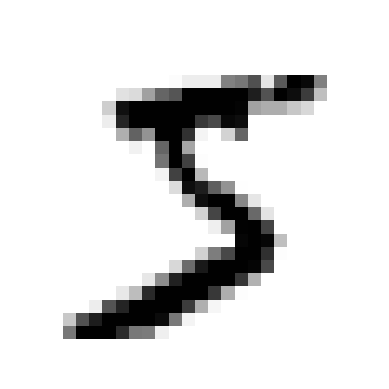

In [9]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

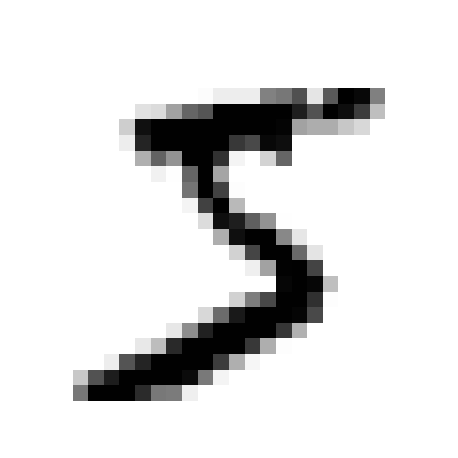

In [10]:
def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

plot_digit(some_digit)
save_fig("some_digit_plot")  # 추가 코드
plt.show()

In [11]:
# 실제 레이블 확인
y[0]

'5'

In [12]:
# 문자열으로 되어있는데 ML 알고리즘은 숫자를 기대하므로 정수로 변환
import numpy as np
y = y.astype(np.uint8)

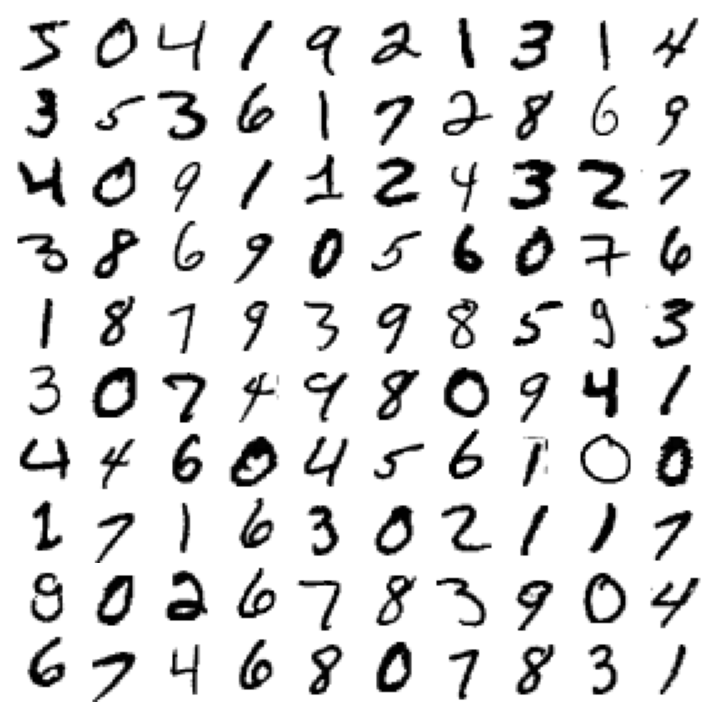

In [13]:
# 추가 코드 – 그림 3–2를 생성하고 저장합니다
plt.figure(figsize=(9, 9))
for idx, image_data in enumerate(X[:100]):
    plt.subplot(10, 10, idx + 1)
    plot_digit(image_data)
plt.subplots_adjust(wspace=0, hspace=0)
save_fig("more_digits_plot", tight_layout=False)
plt.show()

In [14]:
# split train test
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

훈련 샘플에 순서에 민감한 학습 알고리즘이 있음
- 비슷한 샘플이 연이어 나타나면 성능이 나빠지는 경우 데이터셋을 섞으면 됨
  - SGD가 샘플을 섞어야 하는 대표적인 경우
     -  기본적으로 에포크 max_iter마다 훈련 데이터를 다시 섞음
- 시계열 데이터가 섞지 않아야 하는 대표적인 경우


# 3.2 이진 분류기 훈련

In [15]:
y_train_5 = (y_train == 5)  # 5는 True고, 다른 숫자는 모두 False
y_test_5 = (y_test == 5)

사이킷런의 SGDClassifier\
(Stochastic Gradient Descent 확률적 경사 하강법)
- 장점: 매우 큰 데이터셋을 효율적으로 처리
  - bc 한 번에 하나씩 훈련 샘플을 독립적으로 처리
  - thus 온라인 학습에 잘 맞음

In [16]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [17]:
sgd_clf.predict([some_digit])

array([ True])

# 3.3 성능 측정

## 교차 검증을 사용한 정확도 측정
결론적으로 정확도를 분류기의 성능 측정 지표로 선호하지 않음\
특히 불균형한 데이터셋을 다룰 때 더욱

불균형한 데이터셋: \
StratifiedKFold 는 클래스별 비율이 유지되도록 계층적 샘플링을 수행

In [18]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

# Setting a random_state has no effect since shuffle is False.
skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)  # 데이터셋이 미리 섞여 있지 않다면
                                                        # shuffle=True를 추가하세요.
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [19]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

모든 교차 검증 폴드에 대해 정확도가 95% 이상


---

모든 이미지를 '5 아님' 클래스로 불류하는 더미 분류기를 만들어 비교

In [20]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
  def fit(self, X, y=None):
    return self
  def predict(self,X):
    return np.zeros((len(X), 1), dtype=bool)

In [21]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

정확도가 90% 이상\
이미지의 10% 정도만 숫자 5이기 때문에\
무조건 5 아님으로 예측하면 정확히 맞출 확률이 90%

## 오차 행렬 <- 더 좋은 분류기 평가 방법

* cross_val_predict():  k-fold 교차 검증을 수행해 각 테스트 폴드에서 얻은 예측을 반환합니다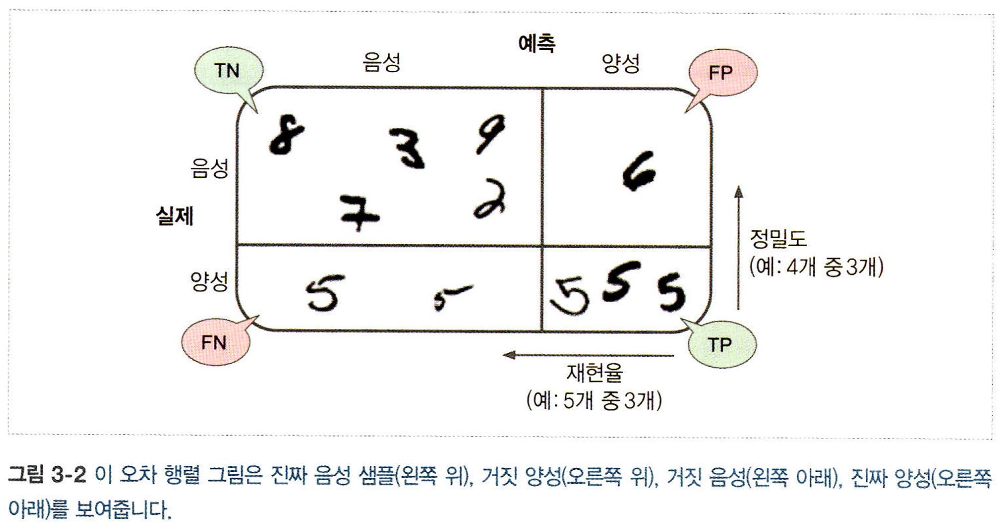

In [22]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [23]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

* row: 실제 클래스 (negative class, positive class)
* col: 예측한 클래스

```
array([negative class: [5아님-true,        5아님-false = 5임],
       positive class: [5아님-false = 5임,  5-true]])
```



In [24]:
y_train_perfect_predictions = y_train_5  # 완벽한 분류기일 경우
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

## 정밀도와 재현율

$정밀도 = \frac{TP}{TP+FP}$\
$재현율 = \frac{TP}{TP+FN}$

In [25]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)  # == 3530 / (687 + 3530)

0.8370879772350012

In [26]:
recall_score(y_train_5, y_train_pred)  # == 3530 / (1891 + 3530)

0.6511713705958311

In [27]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

## 정밀도/재현율 트레이드오프

In [28]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [29]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [30]:
# 임곘값을 높이면 재현율이 줄어듬
threshold = 3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

적절한 임계값 정하기

In [31]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [32]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [33]:
thresholds, precisions

(array([-146348.56726174, -142300.00705404, -137588.97581744, ...,
          38871.26391927,   42216.05562787,   49441.43765905]),
 array([0.09035   , 0.09035151, 0.09035301, ..., 1.        , 1.        ,
        1.        ]))

정밀도 90%를 달성하는 것이 목표일때

In [34]:
idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

3370.0194991439557

In [35]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)

In [36]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

정밀도 90% 달성

In [37]:
recall_at_90_precision = recall_score(y_train_5, y_train_pred_90)
recall_at_90_precision

0.4799852425751706

재현율이 너무 낮다면 높은 정밀도의 분류기는 유용하지 않음

## ROC 곡선
Receiver Operating Characteristic (수신기 조작 특성)
* 이진 분류에서 널리 사용되는 도구
* FPR에 대한 TPR의 곡선
* FPR = 1 - TNR = 1 - 특이도
* ROC 곡선 aka 민감도(재현율)에 대한 1-특이도 그래프

In [38]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

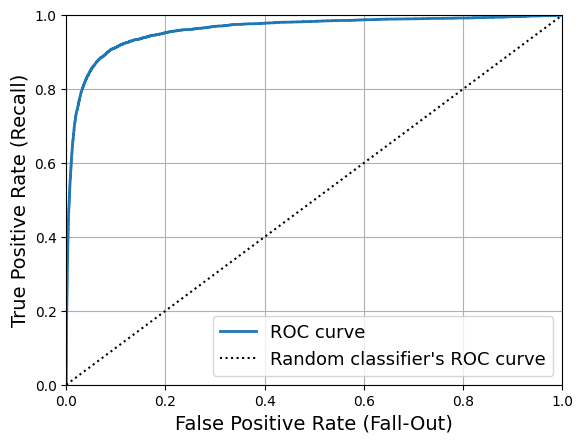

In [49]:
def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
  plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
  plt.xlabel('False Positive Rate (Fall-Out)')
  plt.ylabel('True Positive Rate (Recall)')
  plt.grid()
  plt.axis([0, 1, 0, 1])
  plt.legend(loc="lower right", fontsize=13)

plot_roc_curve(fpr, tpr)
plt.show()

In [42]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

**경고:** 다음 셀은 실행하는데 몇 분이 걸릴 수 있습니다.

In [43]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

In [44]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [47]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

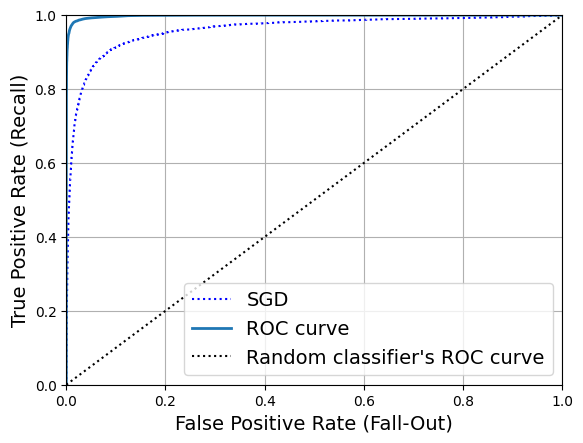

In [50]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [51]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

# 3.4 다중 분류

SVM은 대용량 데이터셋에 잘 맞지 않기 때문에 처음 2,000개의 샘플만 사용해 훈련합니다. 그렇지 않으면 아주 오랜 시간이 걸립니다:

In [52]:
from sklearn.svm import SVC

svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000])  # y_train_5가 아니고 y_train을 사용합니다.

SVC(random_state=42)

In [53]:
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [54]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores.round(2)

array([[ 3.79,  0.73,  6.06,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.21,
         4.82]])

In [55]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])

OneVsRestClassifier(estimator=SVC(random_state=42))

In [56]:
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [57]:
len(ovr_clf.estimators_)

10

In [58]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [59]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

**경고:** 다음 셀은 실행하는데 몇 분이 걸릴 수 있습니다.

In [60]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [61]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype("float64"))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

KeyboardInterrupt: 

# 3.5 에러 분석

**경고:** 다음 셀은 실행하는데 몇 분이 걸릴 수 있습니다.

In [62]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

In [ ]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [ ]:
row_sums = conf_mx.sum(axis = 1, keepdims = True)
norm_conf_mx = conf_mx/row_sums

In [ ]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap = plt.cm.gray)
plt.show()

In [ ]:
cl_a, cl_b = 3,5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

In [ ]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = plt.cm.binary, **options)
    plt.axis("off")

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(221)
plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222)
plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223)
plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224)
plot_digits(X_bb[:25], images_per_row=5)
plt.show()

# 3.6 다중 레이블 분류

In [ ]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= '7')
y_train_odd = (y_train.astype('int8') % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [ ]:
knn_clf.predict([some_digit])

array([[False,  True]])

올바르게 분류됨: 숫자 5는 크지 않고 (False) 홀수임 (True)

**경고:** 다음 셀은 실행하는데 몇 분이 걸릴 수 있습니다:

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

In [ ]:
# 추가 코드 – average="weighted"로 지정했을 때 성능 향상은 무시할 수 있는 수준입니다.
#           이 클래스는 이미 꽤 균형 잡혀 있기 때문입니다.
# f1_score(y_multilabel, y_train_knn_pred, average="weighted")

0.9778357403921755

# 3.7 다중 출력 분류

In [ ]:
np.random.seed(42)
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

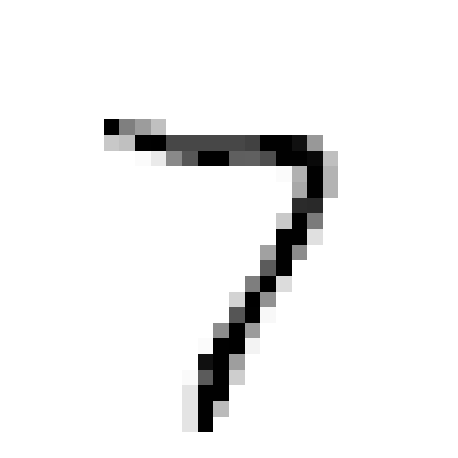

In [ ]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[0]])
plot_digit(clean_digit)
plt.show()